In [144]:
import pickle as pkl
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.api as sm 

In [29]:
datanew, X_train, X_test, y_train, y_test = pkl.load(file=open('./data_to_model.pkl', 'rb'))

In [30]:
datanew.head()

,total_time,amount,store_customer_distance,store_customer_duration,items_found,total_volume,courier_exp,ztl,day_of_the_week_Monday,day_of_the_week_Saturday,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,50.38,22.83,4.519,15.850000,11,23429.190,2103.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,48.64,28.30,6.073,12.350000,9,23313.720,387.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,64.96,24.98,8.132,11.183333,11,17849.920,4216.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,23.56,18.74,0.709,2.800000,3,16605.480,1274.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,43.94,25.00,4.211,8.666667,9,10763.445,452.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [31]:
X_train = datanew.iloc[:110000,1:]
X_test = datanew.iloc[110000:,1:]
y_train =datanew.iloc[:110000,0]
y_test =datanew.iloc[110000:,0]

### RANDOM FOREST REGRESSOR

In [32]:
regr = RandomForestRegressor(n_estimators=100, max_features='sqrt', bootstrap=True, n_jobs=-1)

In [33]:
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

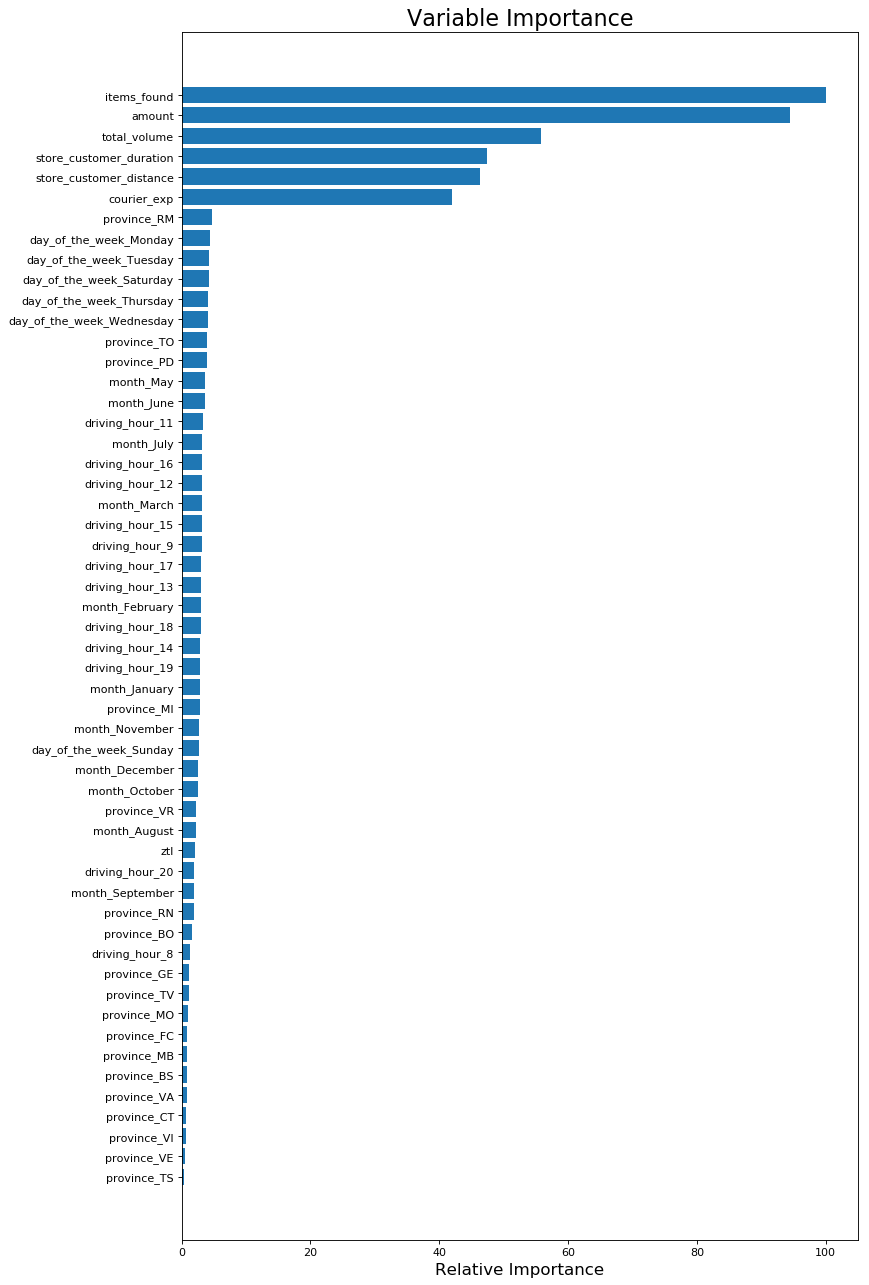

In [168]:
feature_importance = regr.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(24, 20), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance', size = 15)
plt.title('Variable Importance', size = 20)
plt.show()

In [35]:
y_pred = regr.predict(X_test)

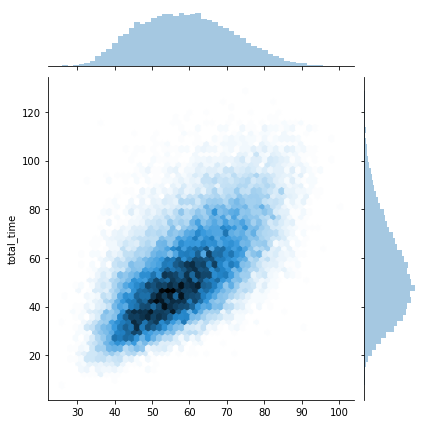

In [36]:
sns.jointplot(y_pred, y_test, kind='hex')

In [37]:
y_val = regr.predict(X_train)
np.sqrt(mean_squared_error(y_val, y_train)), mean_absolute_error(y_val, y_train)

(5.190639184908226, 4.081467967272727)

In [38]:
np.sqrt(mean_squared_error(y_pred, y_test)), mean_absolute_error(y_pred, y_test)

(14.90889587240719, 12.194228624848774)

In [152]:
evaluate(regr, X_test, y_test)

Model Performance
Average Error: 12.1942 minutes.
Accuracy = 73.16%.


73.16493108101969

###### RANDOM GRID SEARCH

In [12]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 6)]
# Number of features to consider at every split
max_features = ['auto','sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 10], 'bootstrap': [True, False]}


#### THE CODE FOR THE OPTIMISATION of THE RANDOM GRID SEARCH can BE SKIPPED - the OPTIMIZATION LED TO the FOLLOWING SET OF PARAMETERS
Uncomment **rf_random** and comment **rf_best** IN THE CODE 2 BLOCKS BELOW - or the other way around depending on what you want to use

Doing a random search of different parameters combination with a cross-validation step allows to search for the best parameters to fit the data together with a recudction of the overfitting

In [14]:
best_grid = {'n_estimators': 250,
             'min_samples_split': 10,
             'min_samples_leaf': 4,
             'max_features': 'sqrt',
             'max_depth': 70,
             'bootstrap': False}

In [21]:
rf = RandomForestRegressor()
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
#                               cv = 3, verbose=3, random_state=42, n_jobs = -1)
rf_best = RandomForestRegressor(n_estimators= 250, min_samples_split = 10, min_samples_leaf=4, max_features='sqrt', max_depth=70, 
             bootstrap=False, verbose=1, random_state=42, n_jobs = -1)

# Fit the random search or the best model model
#rf_random.fit(X_train, y_train)
rf_best.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    5.6s finished


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=70,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
           oob_score=False, random_state=42, verbose=1, warm_start=False)

In [42]:
rf_random.best_params_

{'n_estimators': 250,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': False}

In [22]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} minutes.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [44]:
base_model = RandomForestRegressor(n_estimators=100, max_features='sqrt', bootstrap=True, n_jobs=-1)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 12.1622 minutes.
Accuracy = 73.22%.


In [45]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 12.0765 minutes.
Accuracy = 73.46%.


In [46]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.33%.


### DEEP NEURAL NETWORK

In [39]:
X_train.shape

(110000, 54)

In [40]:
X_train_to_std = X_train.iloc[:,:6]
X_test_to_std = X_test.iloc[:,:6]

In [41]:
X_train_to_std.head()

,amount,store_customer_distance,store_customer_duration,items_found,total_volume,courier_exp
0,22.83,4.519,15.850000,11,23429.190,2103.0
1,28.30,6.073,12.350000,9,23313.720,387.0
2,24.98,8.132,11.183333,11,17849.920,4216.0
3,18.74,0.709,2.800000,3,16605.480,1274.0
4,25.00,4.211,8.666667,9,10763.445,452.0


In [43]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_to_std)
X_test_scaled = sc.transform(X_test_to_std)

/Users/Andrea/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Andrea/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/Andrea/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
X_train_full = np.concatenate((X_train_scaled, X_train.iloc[:,6:].values), axis=1)

In [45]:
X_test_full = np.concatenate((X_test_scaled, X_test.iloc[:,6:].values), axis=1)

In [46]:
X_train_full.shape, X_test_full.shape

((110000, 54), (27277, 54))

In [122]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(54, input_dim=54, kernel_initializer='normal', activation='relu'))
    model.add(Dense(27, kernel_initializer='normal', activation='relu'))
    model.add(Dense(13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [123]:
seed = 0
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=500, verbose=1)

In [124]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X_train_full, y_train.values, cv=kfold, n_jobs=-1)
print("Results: %.2f RMSE" % (np.sqrt(np.abs(results.mean()))))

Results: 15.15 RMSE


In [125]:
estimator.fit(X_test_full, y_test)
prediction = estimator.predict(X_test_full)
mean_absolute_error(prediction, y_test)

Epoch 1/1
27277/27277 [==============================] - 1s 22us/step


11.882795822356686

In [153]:
evaluate(estimator, X_test_full, y_test)

27277/27277 [==============================] - 1s 20us/step
Model Performance
Average Error: 11.8828 minutes.
Accuracy = 75.47%.


75.46747830904809

Predicted vs test set


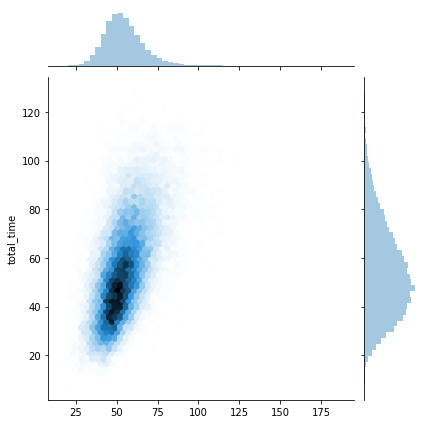

In [158]:
print("Predicted vs test set")
sns.jointplot(prediction, y_test, kind='hex')
plt.show()

### GRADIENT BOOSTING REGRESSOR

In [135]:
param_gbr = {'n_estimators':500, 'max_depth': 6, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls', 'warm_start': True}
clf = GradientBoostingRegressor(**param_gbr)
clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("RMSE: %.4f" % np.sqrt(np.abs(mse)))

RMSE: 14.7792


In [163]:
print(f"Mean absolute error: {mean_absolute_error(y_test, clf.predict(X_test))}")

Mean absolute error: 12.078921099820873


Text(0, 0.5, 'Deviance')

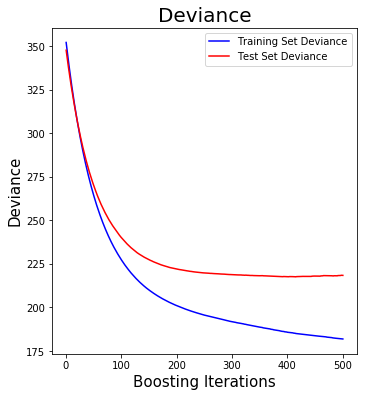

In [140]:
test_score = np.zeros((param_gbr['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance', size=20)
plt.plot(np.arange(param_gbr['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(param_gbr['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations', size=15)
plt.ylabel('Deviance', size=15)

In [162]:
evaluate(clf, X_test, y_test)

Model Performance
Average Error: 12.0789 minutes.
Accuracy = 73.43%.


73.43319274696726

### MULTIPLE LINEAR REGRESSION
The standard multiple linear regression performs poorly compared to the other methods

In [145]:
def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

In [146]:
print(reg_m(y_train, X_train_full.T).summary())

                            OLS Regression Results                            
Dep. Variable:             total_time   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     1371.
Date:                Fri, 08 Feb 2019   Prob (F-statistic):               0.00
Time:                        22:48:44   Log-Likelihood:            -4.5071e+05
No. Observations:              110000   AIC:                         9.015e+05
Df Residuals:                  109945   BIC:                         9.021e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1214      0.275      7.718      0.0

In [149]:
reg_predicted = reg_m(y_train, X_train_full.T).predict(sm.add_constant(X_test_full))

In [151]:
print(f"Mean absolute error: {np.mean(np.abs(reg_predicted-y_test))}")

Mean absolute error: 35.87647194334348


In [161]:
evaluate(reg_m(y_train, X_train_full.T), sm.add_constant(X_test_full), y_test)

Model Performance
Average Error: 35.8765 minutes.
Accuracy = 31.18%.


31.179579685387637